# Random Forest Simple Baseline 

Simple first pass - selected feature with largest correlations and minimal preprocessing to get a sense of baseline

results for whole sample and top 250 (as is the measure for the assignment)

In [1]:
%matplotlib inline
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

np.random.seed(0)

In [9]:
data = pd.read_csv('../data/train_month_3_with_target.csv',parse_dates = [29,30,32], index_col = 'client_id')

y = data.target
X = data[['homebanking_active'
              ,'has_homebanking'
              ,'bal_mortgage_loan'
              ,'has_life_insurance_decreasing_cap'
              ,'has_mortgage_loan'
              ,'has_current_account'
              ,'cap_life_insurance_decreasing_cap'
              ,'bal_savings_account'
              ,'bal_current_account'
              ,'has_personal_loan'
              ,'bal_personal_loan'
         ]]

X.dtypes

homebanking_active                   int64
has_homebanking                      int64
bal_mortgage_loan                    int64
has_life_insurance_decreasing_cap    int64
has_mortgage_loan                    int64
has_current_account                  int64
cap_life_insurance_decreasing_cap    int64
bal_savings_account                  int64
bal_current_account                  int64
has_personal_loan                    int64
bal_personal_loan                    int64
dtype: object

In [10]:
#balance classes 50:50
smt = SMOTE(random_state=42)

#classifier
rf = RandomForestClassifier(max_depth=5,n_estimators = 100,random_state=0)

#pipeline
pipe = Pipeline(
    steps=[("balancer", smt), ("classifier", rf)]
)

# split and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf = pipe.fit(X_train,y_train)

Pipeline(steps=[('balancer', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=0))])


In [5]:
# predict 
y_pred_test = clf.predict(X_test)
y_pred_test_probs = clf.predict_proba(X_test)
y_pred_test_probs = [x[1] for x in y_pred_test_probs] #unzip probabilities to obtain just prob of pos

# extract top 250 
y_pred_250 = pd.DataFrame({'y':y_test,'y_pred':y_pred_test,'y_pred_prob':y_pred_test_probs}).sort_values(by ='y_pred_prob',ascending=False)
y_pred_250 = y_pred_250.head(250)
y_pred_250

,y,y_pred,y_pred_prob
client_id,,,
6fa825d81722d234b2615fff8a3a04c6,0,1,0.794509
f83ad9ccb7ccf363b957b9f8e5fc1d6b,0,1,0.794509
e75caf8a2d29cf2f02210ce2d8b39c81,0,1,0.794509
68d86cc34dba01c7f258df7263ae4bcc,0,1,0.794509
9db10d855953b21b875de4f2f66c61a0,0,1,0.794509
...,...,...,...
95b2dbbd25c6b4ea5b8cb4f734756bfa,0,1,0.782037
2ff8683d01bbd42f90832c6fe6bbcf07,0,1,0.782037
1fecba3c3d9faef6df944516caabd694,0,1,0.781674


model accuracy score: 0.706


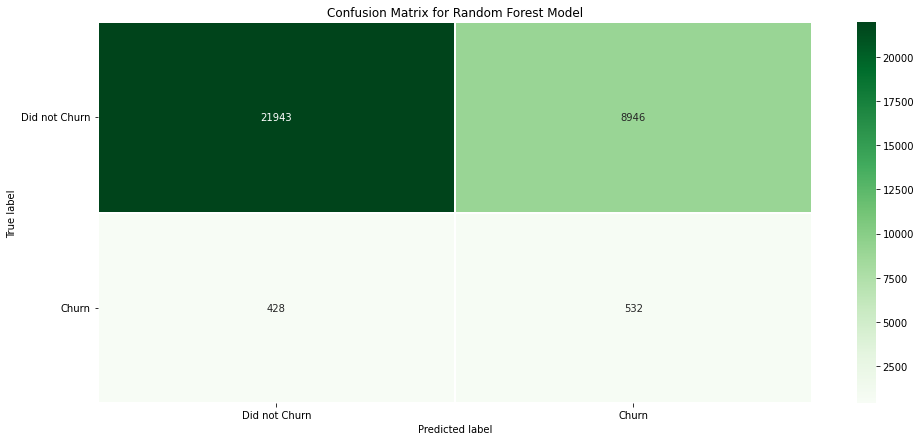

               precision    recall  f1-score   support

Did not Churn       0.98      0.71      0.82     30889
        Churn       0.06      0.55      0.10       960

     accuracy                           0.71     31849
    macro avg       0.52      0.63      0.46     31849
 weighted avg       0.95      0.71      0.80     31849



In [14]:
#### EVALUATE: whole set

from sklearn.metrics import accuracy_score, precision_score,confusion_matrix, classification_report,auc
from sklearn.metrics import roc_curve,auc

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, 
            annot=True,
            fmt='g',
            cmap=plt.cm.Greens, 
            linewidths=0.2)

# Add labels to the plot
class_names = ['Did not Churn', 'Churn']
tick_marks = np.arange(len(class_names))+0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')

print("model accuracy score: %.3f" % clf.score(X_test, y_test))
plt.show()

print(classification_report(y_test, y_pred_test,target_names = class_names))

               precision    recall  f1-score   support

Did not Churn       0.00      0.00      0.00       227
        Churn       0.09      1.00      0.17        23

     accuracy                           0.09       250
    macro avg       0.05      0.50      0.08       250
 weighted avg       0.01      0.09      0.02       250

model ACU score: 0.500


/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


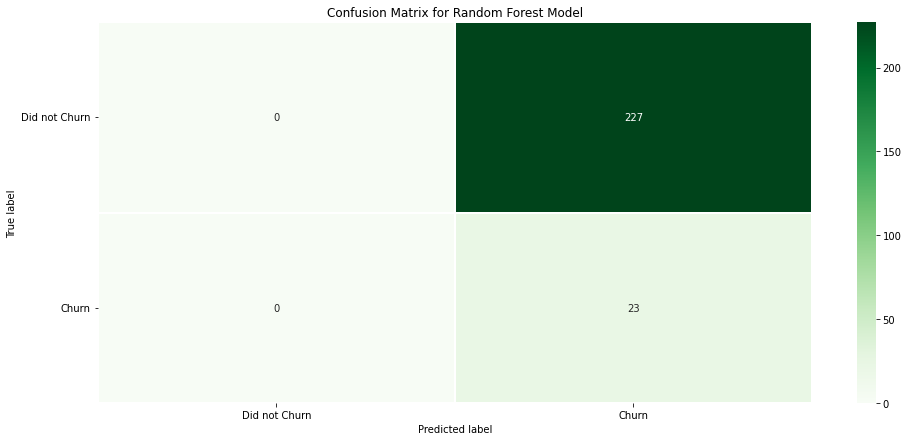

In [15]:
#### EVALUATE: top 250 set

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_pred_250.y, y_pred_250.y_pred)

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, 
            annot=True,
            fmt='g',
            cmap=plt.cm.Greens, 
            linewidths=0.2)

# Add labels to the plot
class_names = ['Did not Churn', 'Churn']
tick_marks = np.arange(len(class_names)) +0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')

print(classification_report(y_pred_250.y, y_pred_250.y_pred,target_names = class_names))

fpr, tpr, thresholds = roc_curve(y_pred_250.y, y_pred_250.y_pred)
print("model ACU score: %.3f" % (auc(fpr, tpr)))